TF-IDF is the original Google salient terms algorithm. It is the product of term frequency and inverse document frequency, aiming to define the importance of a keyword within a corpus. 

We use it here to see which non-Michelin restaurants are most closely related Michelins (per reviews). 

# Implementation

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
current_directory = os.getcwd()
file_path = 'restaurant_reviews.csv' #Download this CSV(df_final_restaurants) via data_processing.ipynb 
df_restaurant_reviews = pd.read_csv(os.path.join(current_directory, file_path), index_col=0)

/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_96102/1057503786.py:3: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_restaurant_reviews = pd.read_csv(os.path.join(current_directory, file_path), index_col=0)


In [3]:
#Get reviews for all restaurants into one large dictionary (restaurant : concatenated string of all its reviews).
restaurant_docs = {}
for restaurant, data in df_restaurant_reviews.groupby('restaurant'):
    restaurant_docs[restaurant] = ' '.join(data['comment.text'])

In [4]:
with open('michelin_alias.json') as fp:
    michelins = set(json.load(fp).values()) 

In [5]:
#Concatenate all reviews from Michelin restaurants into a "michelin document" or mega string.
michelin_doc = ' '.join(doc for restaurant, doc in restaurant_docs.items() if restaurant in michelins)

Now, let's use TF-IDF to determine the similarities between each restaurant "document" and the "michelin document". The idea is that the restaurants with the highest similarities are most likely to be Michelin restaurants. The high ranking restaurants that are not already Michelin might be more likely to become Michelin in the future.

In [6]:
aliases = ['michelin_doc'] + list(restaurant_docs.keys())
documents = [michelin_doc] + list(restaurant_docs.values())

In [7]:
tfidf = TfidfVectorizer().fit_transform(documents)
similarities = tfidf[0] * tfidf.T

Create and rank the dataframe by similarity to the "michelin document".

In [8]:
df_similarity = pd.DataFrame({
    "alias": aliases,
    "similarity": similarities.todense().tolist()[0], #Compare each individual restaurant to the overall Michelin reviews.
    "michelin": [a in michelins for a in aliases]
})

In [9]:
df_similarity.sort_values(by="similarity", ascending=False, inplace=True)
df_similarity["rank"] = range(len(df_similarity))

# Results

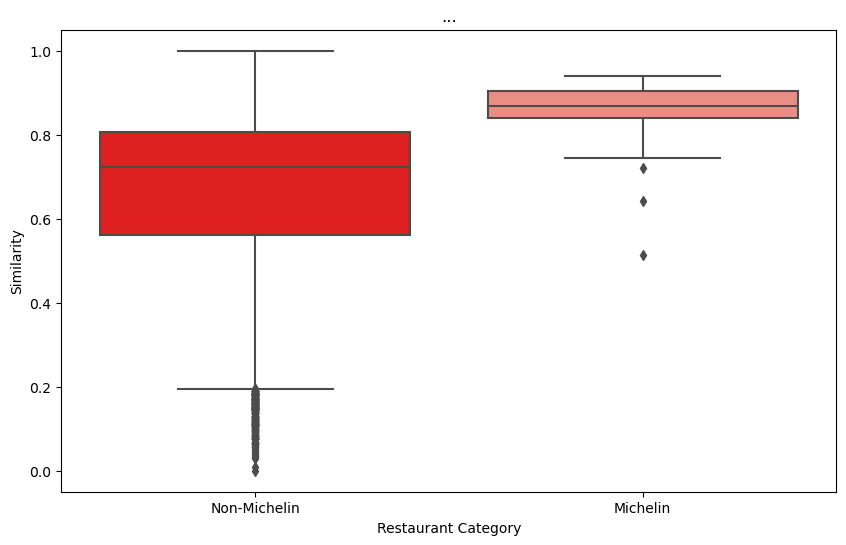

In [10]:
#Let's prove our Michelin vs non-Michelin are well isolated by TF-IDF. 
michelins = df_similarity[df_similarity['michelin'] == 1]
non_michelins = df_similarity[df_similarity['michelin'] != 1]

plt.figure(figsize=(10, 6))
sns.boxplot(x='michelin', y='similarity', data=pd.concat([michelins, non_michelins]), palette={0: 'red', 1: 'salmon'})

plt.xlabel('Restaurant Category')
plt.ylabel('Similarity')
plt.title('...')
plt.xticks(ticks=[1, 0], labels=['Michelin', 'Non-Michelin'])
plt.show()

In [11]:
#Now let's deepdive. Restaurants most similar to the "michelin document".
df_similarity.head(10)

,alias,similarity,michelin,rank
0,michelin_doc,1.000000,False,0
1933,chefs-table-at-brooklyn-fare-new-york,0.940698,False,1
9810,the-modern-new-york-3,0.940447,True,2
3572,gabriel-kreuther-new-york,0.932203,True,3
8554,sixty-three-clinton-new-york,0.932164,True,4
7057,one-white-street-new-york,0.932111,True,5
6438,momofuku-ko-new-york-3,0.931969,False,6
1812,cathédrale-restaurant-new-york-city,0.930357,False,7
1809,catch-nyc-new-york,0.926517,False,8
10386,vestry-new-york,0.925894,True,9


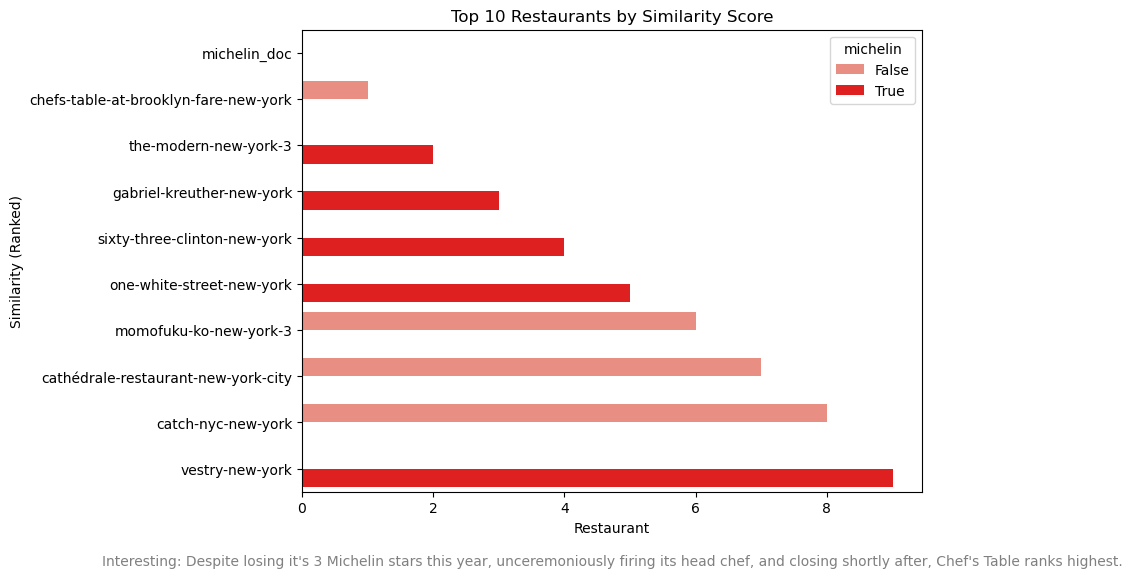

In [12]:
top_10 = df_similarity.head(10)

plt.figure(figsize=(8, 6)) 
sns.barplot(x='rank', y='alias', hue='michelin', data=top_10, palette = {0: 'salmon', 1: 'red'})

plt.title('Top 10 Restaurants by Similarity Score')
plt.xlabel('Restaurant')
plt.ylabel('Similarity (Ranked)')
plt.annotate("Interesting: Despite losing it's 3 Michelin stars this year, unceremoniously firing its head chef, and closing shortly after, Chef's Table ranks highest.", 
             xy=(0.5, -0.15), xycoords='axes fraction',
             ha='center', va='center', fontsize=10, color='gray')
plt.show()

In [13]:
#Ranks of Michelin restaurants most similar to the "michelin document".
df_similarity[df_similarity["michelin"] == True].head(10)

,alias,similarity,michelin,rank
9810,the-modern-new-york-3,0.940447,True,2
3572,gabriel-kreuther-new-york,0.932203,True,3
8554,sixty-three-clinton-new-york,0.932164,True,4
7057,one-white-street-new-york,0.932111,True,5
10386,vestry-new-york,0.925894,True,9
5424,le-bernardin-new-york,0.922247,True,13
9817,the-musket-room-new-york,0.921416,True,15
5481,le-pavillon-new-york,0.919724,True,16
7942,red-paper-clip-new-york,0.915057,True,22
4584,jean-georges-new-york-2,0.914246,True,25


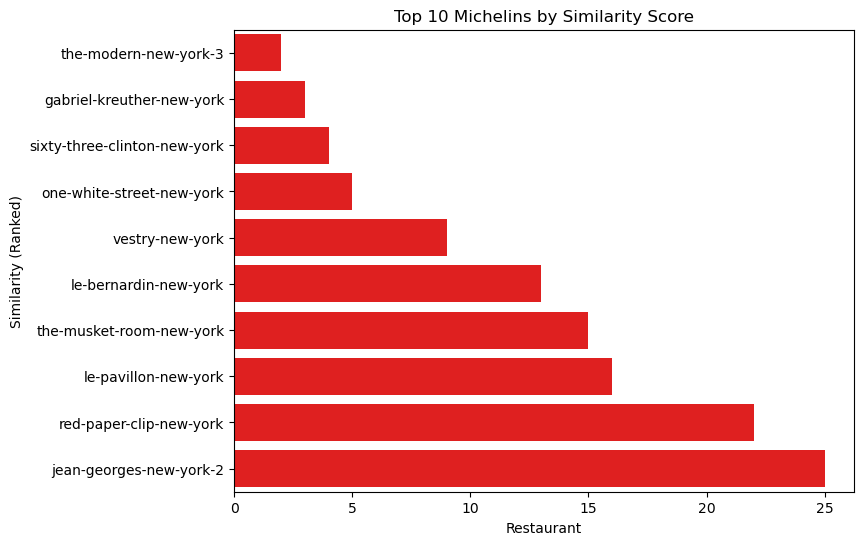

In [20]:
plt.figure(figsize=(8, 6)) 
sns.barplot(x='rank', y='alias', data=df_similarity[df_similarity["michelin"] == True].head(10), color = 'red')

plt.title('Top 10 Michelins by Similarity Score')
plt.xlabel('Restaurant')
plt.ylabel('Similarity (Ranked)')
plt.show()

## Add our data to the restaurant details dataframe for further analysis.

In [15]:
current_directory = os.getcwd()
file_path = 'restaurant_details.csv'
df_restaurants = pd.read_csv(os.path.join(current_directory, file_path), index_col=0)

df_restaurants = df_restaurants.merge(df_similarity, on="alias")

Show the restaurant with the highest similarity to the "michelin document" by group. 

In [16]:
"""pd.set_option('display.max_rows', None)
def display_highest_in_group(df, group):
 display(df[["name", "similarity", "rank", "michelin", group]].groupby(group).first().sort_values(by='similarity', ascending=False))"""

def display_highest_in_group(df, group):
    pd.set_option('display.max_rows', None)
    display(df[["name", "similarity", "rank", "michelin", group]].groupby(group, observed=True).first().sort_values(by='similarity', ascending=False))
    pd.set_option('display.max_rows', 50)

In [248]:
#Cuisines with highest Michelin similarity
display_highest_in_group(df_restaurants, "category_0")

,name,similarity,rank,michelin
category_0,,,,
Greek,Skinos,0.912879,32,False
Brasseries,Frenchette,0.909912,49,False
Dim Sum,Brooklyn Chop House,0.904986,70,False
Modern European,Queensyard,0.900266,103,False
Australian,Hole In The Wall,0.893199,173,False
American,P.J. Clarke's,0.892413,187,False
Seafood,Mezze on the River,0.889305,228,False
Argentine,Porteno Restaurant,0.882526,357,False
Tapas/Small Plates,Terra Wine Bar,0.875397,514,False


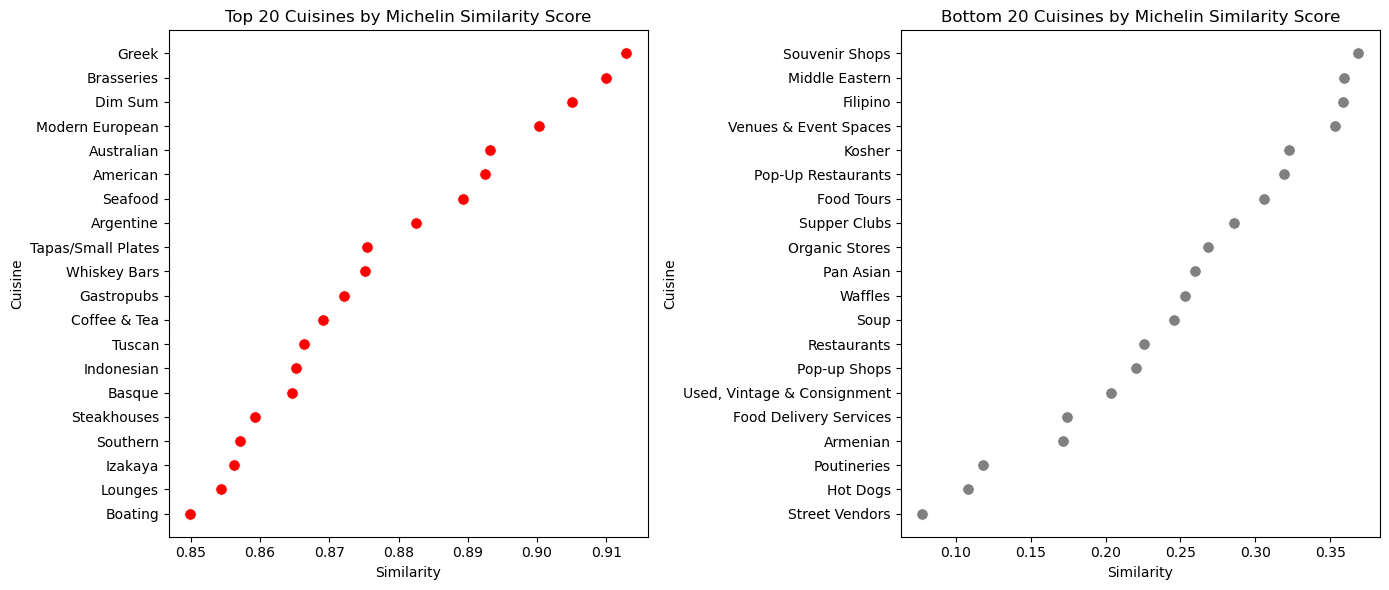

In [243]:
top_10_cuisine = df_restaurants[["name", "similarity", "rank", "michelin", "category_0"]].groupby("category_0", observed=True).first().sort_values(by='similarity', ascending=False)
top_10_cuisine.reset_index(inplace=True)
top_10_cuisine.rename(columns={"category_0": "cuisine"}, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='similarity', y="cuisine", data=top_10_cuisine.head(20), color='red', s=70, ax=axes[0])
axes[0].set_title('Top 20 Cuisines by Michelin Similarity Score')
axes[0].set_xlabel('Similarity')
axes[0].set_ylabel('Cuisine')

sns.scatterplot(x='similarity', y="cuisine", data=top_10_cuisine.tail(20), color='grey', s=70, ax=axes[1])
axes[1].set_title('Bottom 20 Cuisines by Michelin Similarity Score')
axes[1].set_xlabel('Similarity')
axes[1].set_ylabel('Cuisine')

plt.tight_layout()
plt.show()

In [233]:
bin_size = 1000
bins = range(0, df_restaurants['review_count'].max() + bin_size, bin_size)
labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]

df_restaurants['review_cnt_bins'] = pd.cut(df_restaurants['review_count'], bins=bins, labels=labels)

In [234]:
#Review bins by restaurants with highest Michelin similarity
display_highest_in_group(df_restaurants, "review_cnt_bins")

#Among food places with low reviews(0-999), Le Pain Quotidian has the highest similarity score to Michelins.

,name,similarity,rank,michelin
review_cnt_bins,,,,
4000-4999,Buddakan,0.880944,393,False
3000-3999,Cafeteria,0.874631,536,False
0-999,Le Pain Quotidien,0.869112,681,False
1000-1999,Eataly NYC Downtown,0.843471,1479,False
7000-7999,Joe's Shanghai,0.819851,2284,False
6000-6999,Lombardi's Pizza,0.764118,4264,False
15000-15999,Katz's Delicatessen,0.740018,5016,False
10000-10999,Ippudo NY,0.732199,5217,False
2000-2999,NY Pizza Suprema,0.699823,6038,False
